In [1]:
# 데이터 다운로드
# !kaggle competitions download -c kaggle-survey-2021

# 캐글러 대상 설문조사
- 설문기간 : 2021년 9월 1일부터 2021년 10월 4일까지
- 171개 국가 및 지역에서 25,973명의 응답자
- 특정 국가 및 지역의 응답자가 50명 미만인 경우 익명성을 위해 '기타'그룹으로 그룹화
- 캐글 이메일, 캐글 웹사이트, 캐글 트위터로 설문 진행

In [32]:
# 패키지 불러오기
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings 감추기
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
%matplotlib inline
plt.rcParams['axes.grid.axis'] = 'both' # 격자 기본 설정
plt.rcParams['axes.axisbelow'] = True # 그래프 뒤에 나타나도록 설정

In [96]:
# 한글 깨짐 설정
# Matplotlib 한글 폰트 오류 해결
from matplotlib import font_manager, rc
font_path = "./malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family = font_name)

In [3]:
# 데이터 불러오기
question = pd.read_csv('./data/kaggle_survey_2021_responses.csv')
question.shape

(25974, 369)

## 데이터 확인하기
- 368개의 문항과 25973개의 응답 존재
- 첫 행 : 문항 세부 내용

In [4]:
question.head()
que = question.iloc[0] # 질문 세부사항
answer = question.iloc[1:] # 답변 목록

<AxesSubplot:>

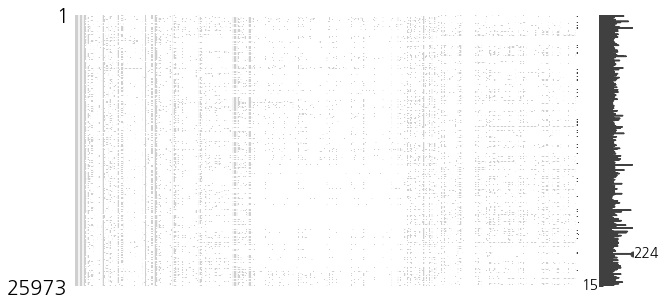

In [5]:
# missingno : NaN 데이터들에 대해 시각화 해준다.
# NaN 데이터 컬럼이 많아 아래 그래프만으로는 내용 파악이 어렵다.
import missingno as msno
msno.matrix(answer, figsize=(10,5))

## 설문 통계

### 성별 
Q2. 'What is your gender? - Selected Choice'

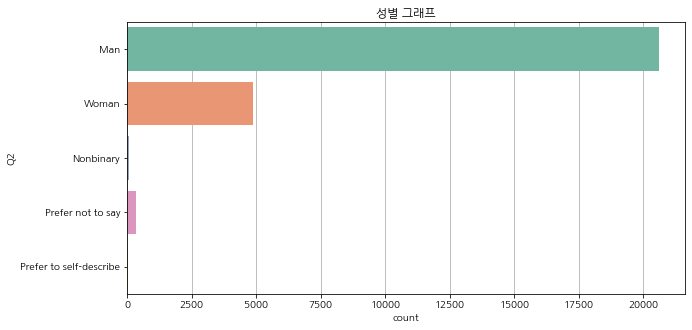

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(y='Q2', data=answer, palette='Set2')
plt.title('성별 그래프')
plt.show()

여성보다는 남성의 비율이 훨씬 높은 편이다. 

### 단일 응답 항목 그래프 함수 작성

In [5]:
# Question Number를 넘겨주면 어떤 질문인지 반환하는 함수
def get_question_title_by_qno(qno):
    if qno in question.columns:
        return question[qno][0]
    else:
        q_no = question.filter(regex=qno).iloc[0,0].split("-")[0] # qno가 들어가는 question 추출, 그 중 하나만 반환
        return q_no

In [6]:
def show_countplot_by_qno(answer, qno, odr=None, title=None):
    if not odr:
        if not title:
            odr = answer[qno].value_counts().index
            sns.countplot(data = answer, y=qno, palette='Greens_r', order = odr).set_title(get_question_title_by_qno(qno))
        else:
            odr = answer[qno].value_counts().index
            sns.countplot(data = answer, y=qno, palette='Greens_r', order = odr).set_title(title)

### 국가별 응답 수
Q3. 'In which country do you currently reside?'

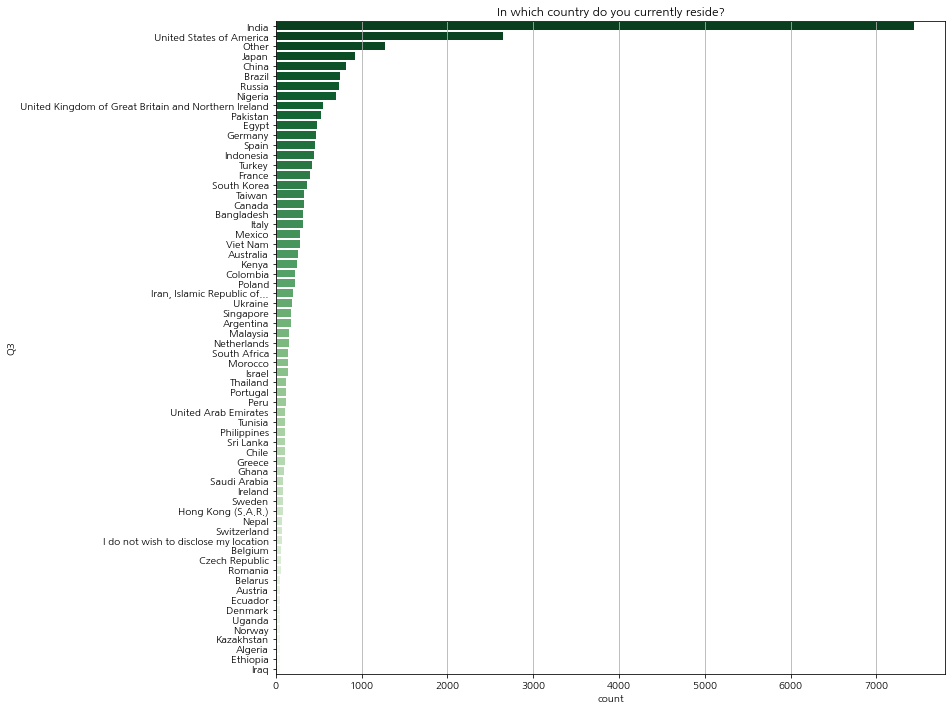

In [30]:
plt.figure(figsize=(12,12))
show_countplot_by_qno(answer, 'Q3')

In [7]:
# 국가별 구체적 응답 수 확인
con_df = pd.DataFrame(answer['Q3'].value_counts())
print(con_df)
con_df['국가'] = con_df.index
# 컬럼의 순서대로 응답 수, 국가로 컬럼명 지정
con_df.columns = ['응답 수','국가']
# index 컬럼 삭제하고 순위를 알기 위해 reset_index() 해준다.
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head(20)

                            Q3
India                     7434
United States of America  2650
Other                     1270
Japan                      921
China                      814
...                        ...
Kazakhstan                  45
Norway                      45
Algeria                     44
Iraq                        43
Ethiopia                    43

[66 rows x 1 columns]


,응답 수,국가
0,7434,India
1,2650,United States of America
2,1270,Other
3,921,Japan
4,814,China
5,751,Brazil
6,742,Russia
7,702,Nigeria
8,550,United Kingdom of Great Britain and Northern I...
9,530,Pakistan


전체 52개국 중 20위까지만 확인함.   
우리나라는 16위에 위치하고 있으며 1위는 인도, 2위는 미국임.

### 나이
Q1. What is your age (#years)?

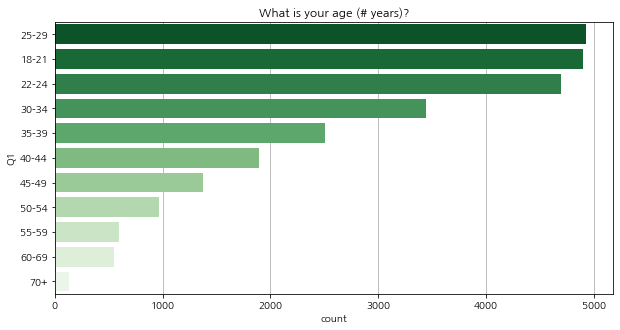

In [34]:
plt.figure(figsize=(10,5))
show_countplot_by_qno(answer,'Q1')

  응답자의 대부분이 20대이며, 나이대가 높아지면서 응답자 수가 감소하는 경향이 보인다.

### 학력
Q4 : 이미 취득했거나 향후 2년 이내 취득 계획이 있는 가장 높은 학력은 ?

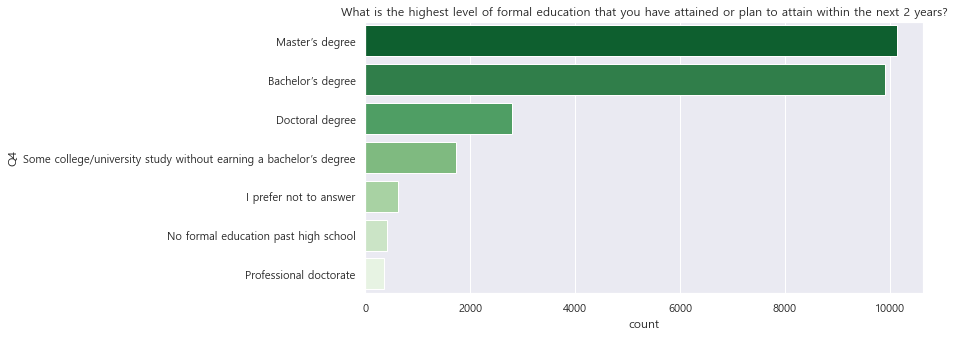

In [372]:
show_countplot_by_qno(answer,'Q4')

학사 학위를 가진 사람과 석사 학위를 가진 사람의 수가 비슷하며 석사 학위를 가진 사람의 수가 약간 많다.   
박사 학위를 가진 사람들도 많다.

### 직업

In [11]:
# normalize=True 옵션 : 해당 데이터가 전체 데이터에서 어느정도의 비율을 차지하는지 알 수 있다.
answer_role_count = pd.DataFrame(answer['Q5'].value_counts())
answer_role_percent = pd.DataFrame(answer['Q5'].value_counts(normalize=True))
answer_role_df = answer_role_count.merge(answer_role_percent, left_index=True, right_index=True)
answer_role_df.columns = ['응답 수','비율']
answer_role_df

,응답 수,비율
Student,6804,0.261964
Data Scientist,3616,0.139221
Software Engineer,2449,0.094290
Other,2393,0.092134
Data Analyst,2301,0.088592
Currently not employed,1986,0.076464
Research Scientist,1538,0.059215
Machine Learning Engineer,1499,0.057714
Business Analyst,968,0.037269
Program/Project Manager,849,0.032688


응답자의 26%가 학생이고, 다음으로 데이터 사이언티스트, 소프트웨어 엔지니어, 데이터분석가 순이다.

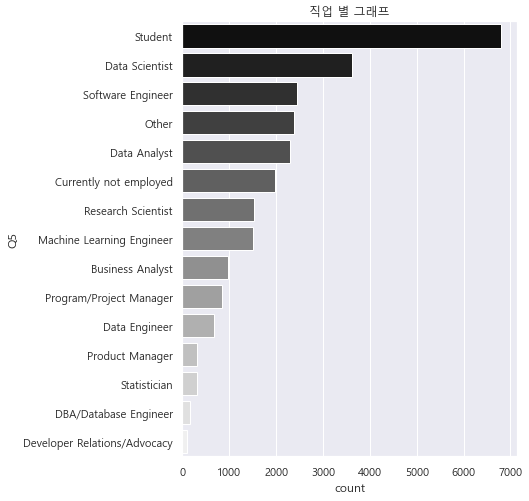

In [316]:
# 직업 시각화
plt.figure(figsize=(6,8))
sns.countplot(y='Q5', data=answer, order=answer['Q5'].value_counts().index, palette='binary_r')
plt.title('직업 별 그래프')
plt.show()

### 프로그래밍 경험
Q6. 'For how many years have you been writing code and/or programming?'

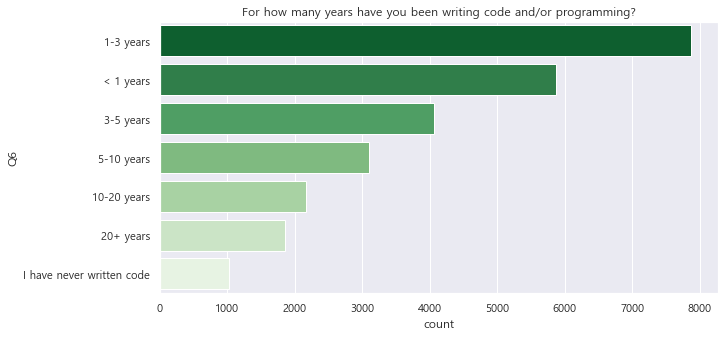

In [373]:
show_countplot_by_qno(answer,'Q6')

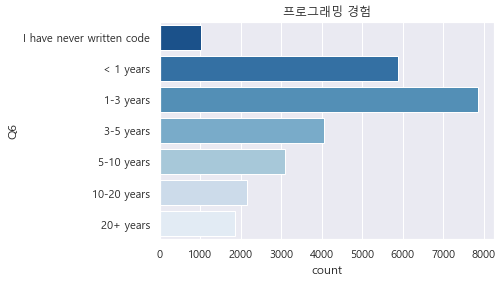

In [351]:
q6_cols = ['I have never written code','< 1 years','1-3 years','3-5 years',
           '5-10 years','10-20 years','20+ years']
sns.countplot(y='Q6', data=answer, order=q6_cols, palette="Blues_r")
plt.title('프로그래밍 경험')
plt.show()

1-3년의 경험을 가진 사람이 가장 많고, 1년 미만의 경험을 가진 사람이 그 다음으로 많다.   
( 과거 2017년의 설문 결과와 비교해보면 프로그래밍 뉴비들이 많이 늘어난 것 같음 ! )

### 한국

The number of interviewees in Korea: 359


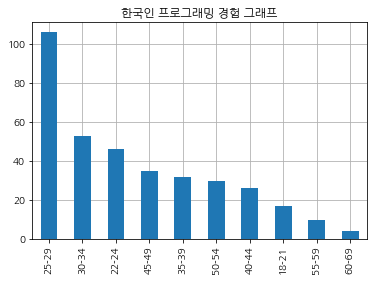

In [35]:
# 프로그래밍 경험
korea = answer.loc[(answer['Q3']=='South Korea')]

print("The number of interviewees in Korea: " + str(korea.shape[0]))

korea['Q1'].value_counts().plot.bar()
plt.title('한국인 프로그래밍 경험 그래프')
plt.show()

우리나라의 경우 20대후반과 30대 초반이 가장 많고, 전체 나라에서의 그래프와 비교했을 때 18-21세의 순위가 매우 낮은 것을 확인할 수 있다.   
(캐글을 몰라서 ? ?)

In [15]:
# 성별
pd.DataFrame(korea['Q2'].value_counts())

,Q2
Man,283
Woman,72
Prefer not to say,4


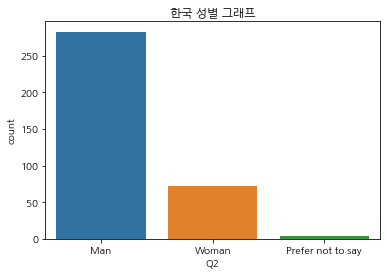

In [18]:
sns.countplot(x='Q2', data=korea)
plt.title('한국 성별 그래프')
plt.show()

남성이 여성보다 훨씬 많다.

<AxesSubplot:title={'center':'Pandas - Age & Gender'}, xlabel='Q1'>

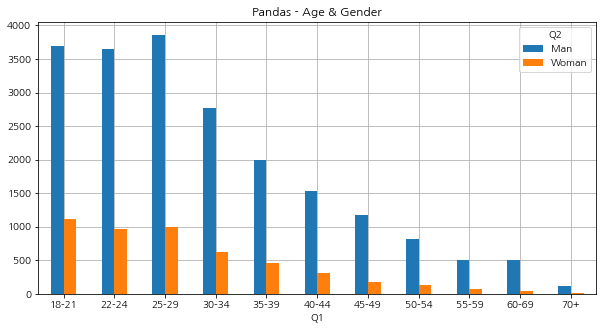

In [62]:
# 연령대 별 성별 분포
# 두 개의 변수에 대해 빈도수를 세고싶은 경우
# pandas로 그리기
q1q2 = pd.crosstab(answer['Q1'],answer['Q2'])
q1q2[['Man','Woman']].sort_index().plot.bar(rot = 0,figsize=(10,5), title = 'Pandas - Age & Gender')

여성과 남성 모두 20대 후반이 가장 많고 나이대가 증가할수록 여성의 비율이 감소한다.

Text(0.5, 1.0, 'Seaborn - Gender&Age')

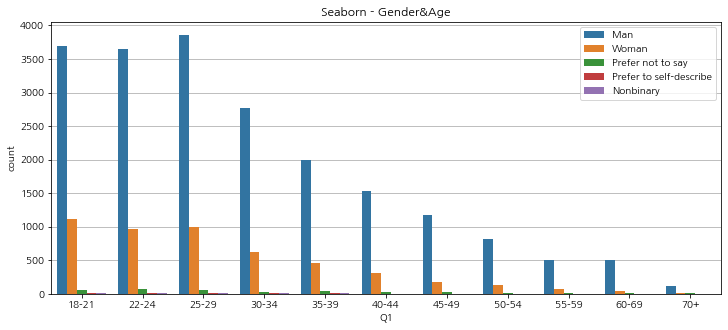

In [61]:
# seaborn으로 그려보기 
plt.figure(figsize=(12,5))
sns.countplot(data=answer.sort_values('Q1'), x='Q1', hue='Q2')
plt.legend(loc='upper right')
plt.title('Seaborn - Gender&Age')

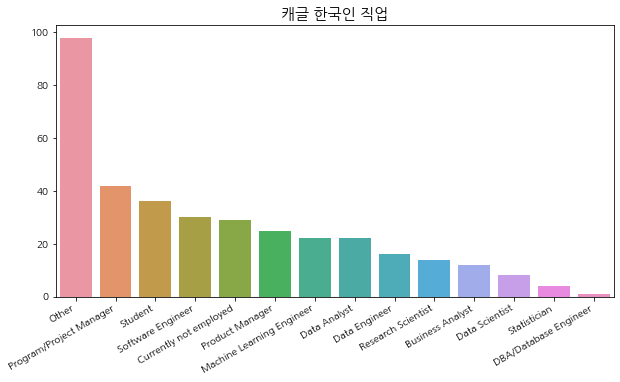

In [40]:
# 직업
plt.figure(figsize=(10,5))
sns.barplot(x=korea['Q5'].unique(), y=korea['Q5'].value_counts())
plt.xticks(rotation=30, ha='right')
plt.title('캐글 한국인 직업', fontsize=15)
plt.ylabel('')
plt.show()

PM이 가장 많고, 다음으로 학생, 소프트웨어엔지니어, 비 고용상태 순이다.

## 자주 묻는 질문 FAQ
- 초보자들이 묻는 가장 일반적인 질문에 대한 답을 시각화 해본다.

## Q1. Python과 R중 어떤 언어를 배워야 할까요 ? 

Q7. What programming languages do you use on a regular basis? 
- 질문에 대한 답 다중 선택이 가능함. 
- 각 언어가 열별로 구성되어 해당 언어를 선택한 사용자외에는 NaN으로 처리되어있음(Q7_Part_1 ~ Q7_OTHER)

Q8. What programming language would you recommend an aspiring data scientist to learn first?

In [67]:
# Q7에 대한 질문만 인덱싱
Q7 = answer.loc[:,'Q7_Part_1':'Q7_OTHER']
# 열이름 변경
Q7.columns = ['Python','R','SQL','C','C++','Java','Javascript','Julia','Swift','Bash','MATLAB','None','Other']
Q7.head()

,Python,R,SQL,C,C++,Java,Javascript,Julia,Swift,Bash,MATLAB,None,Other
1,Python,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,SQL,C,C++,Java,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Python,NaN,NaN,NaN,C++,Java,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Python,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,MATLAB,NaN,NaN


In [112]:
# 응답 별 개수 세기
Q7_answer = Q7.count()
Q7_answer.sort_values(ascending=False, inplace=True)

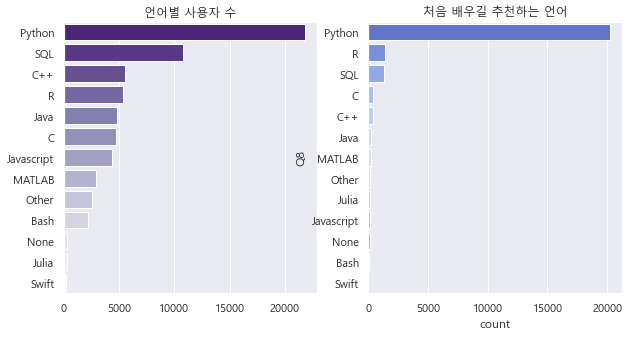

In [357]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
sns.barplot(y=Q7_answer.index, x=Q7_answer.values, palette='Purples_r')
plt.title('언어별 사용자 수')

plt.subplot(1,2,2)
sns.countplot(y='Q8', data=answer, palette='coolwarm', order = answer['Q8'].value_counts().index)
plt.title('처음 배우길 추천하는 언어')
plt.show()

첫번째 그래프를 통해 현재 사용자들은 파이썬,SQL,C++,R 순으로 많이 사용하는 것을 알 수 있고   
두번째 그래프를 통해 파이썬,R,SQL 순으로 먼저 배우길 추천하는 것을 알 수 있다.   
∴ R보다는 파이썬을 명확하게 선호하는 것으로 보인다.

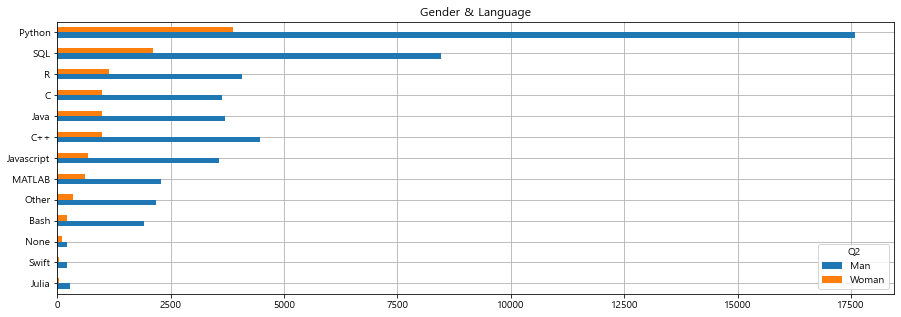

In [133]:
# 성별 언어별 사용자 수 
q7_cols = answer.filter(regex='Q7').describe().loc['top'].tolist()
q2q7 = answer.filter(regex='Q7|Q2$')
q2q7_count = q2q7.groupby('Q2').count()
q2q7_count.columns = q7_cols

g = q2q7_count.loc[['Man','Woman']].T.sort_values('Woman').plot.barh(figsize=(15,5), title='Gender & Language')

응답자 중 여성의 경우 파이썬, SQL, R 순으로 사용자가 많고 남성의 경우 파이썬, SQL, C++ 순으로 많다.

### 다중 응답 항목 그래프 함수 작성

In [7]:
# Question Number를 넘겨주면 선택지에 대한 응답값을 빈도수로 반환하는 함수
def get_multiple_choice_answer_by_qno(answer,qno):
    df_answer = answer.filter(regex=qno)
    answer_desc = df_answer.describe()
    answer_count = answer_desc.loc[["top","count"]].T.set_index("top")
    answer_count = answer_count.sort_values("count", ascending=False)
    return answer_count

In [8]:
# 다중 응답 항목 그래프로 그려주는 함수
def show_multiple_choice_bar_plot_by_qno(answer,qno,title=None):
    multiple_choice_answer = get_multiple_choice_answer_by_qno(answer,qno)
    if not title:
        sns.barplot(data=multiple_choice_answer, y=multiple_choice_answer.index,
                   x="count", palette='Blues_r').set_title(get_question_title_by_qno(qno))
    else:
        sns.barplot(data=multiple_choice_answer, y=multiple_choice_answer.index,
                   x="count", palette='Blues_r').set_title(title)

#### 전문가와 강사들이 선호하는 언어 알아보기
현재 직업이 Data Scientist, Data Analyst, Machine Learning Engineer, Data Engineer, DBA/Database Engineer인 사람들로 직업을 특정하여 위 그래프를 다시 그려봄

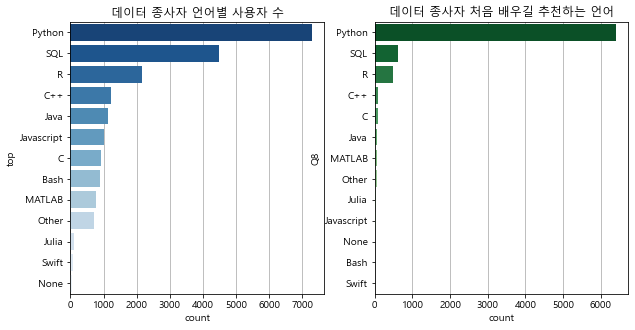

In [236]:
data_cols = answer['Q5'][answer['Q5'].str.contains('Data|Machine')]
data_idx = data_cols.index
data_expert = answer.loc[data_idx]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
show_multiple_choice_bar_plot_by_qno(data_expert,'Q7',title='데이터 종사자 언어별 사용자 수')
plt.subplot(1,2,2)
show_countplot_by_qno(data_expert,'Q8',title='데이터 종사자 처음 배우길 추천하는 언어')
plt.show()

In [127]:
get_multiple_choice_answer_by_qno(answer,'Q7')

,count
top,
Python,21860
SQL,10756
C++,5535
R,5334
Java,4769
C,4709
Javascript,4332
MATLAB,2935
Other,2575


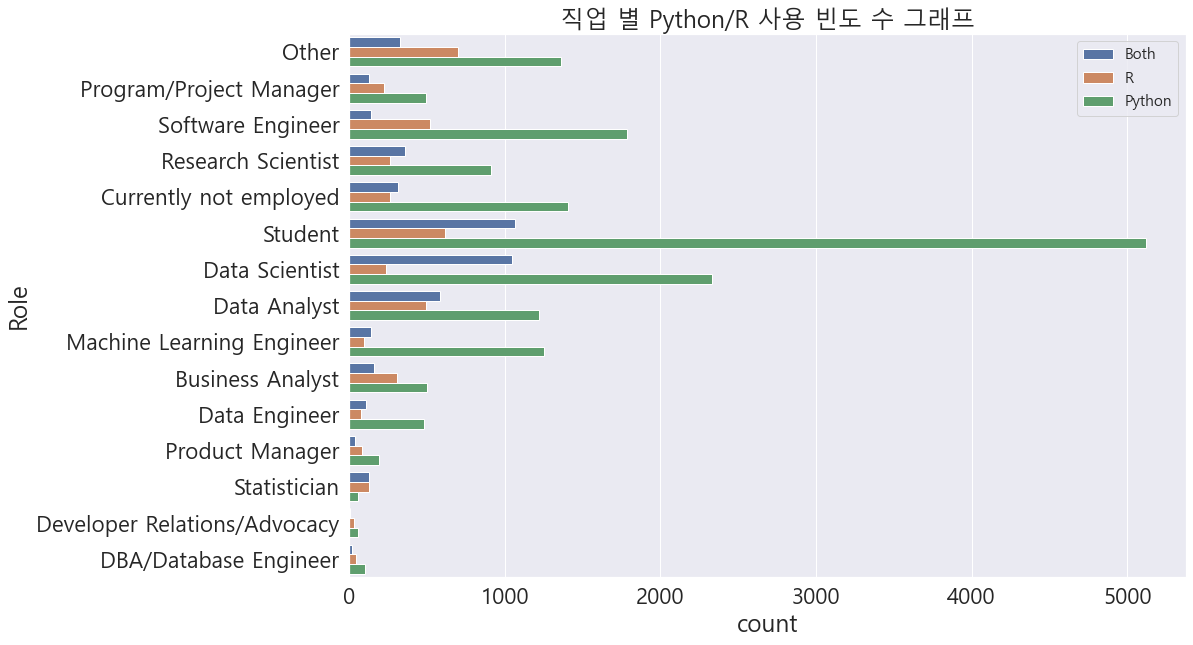

In [203]:
# 업종 별 Python/R 사용 빈도 수 
def language(answer):
    if (answer['Q7_Part_1']=='Python') & (answer['Q7_Part_2']=='R'): # Python, R 모두 선택
        return 'Both'
    elif answer['Q7_Part_1']=='Python': # Python만
        return 'Python'
    else: # R만
        return 'R'
answer['lang'] = answer.apply(lambda x: language(x), axis=1)
plt.figure(figsize=(15,10))
sns.countplot(y='Q5', hue='lang', data=answer, palette='deep')
plt.ylabel('Role')
plt.title('직업 별 Python/R 사용 빈도 수 그래프')
plt.legend(fontsize=15)
plt.show()

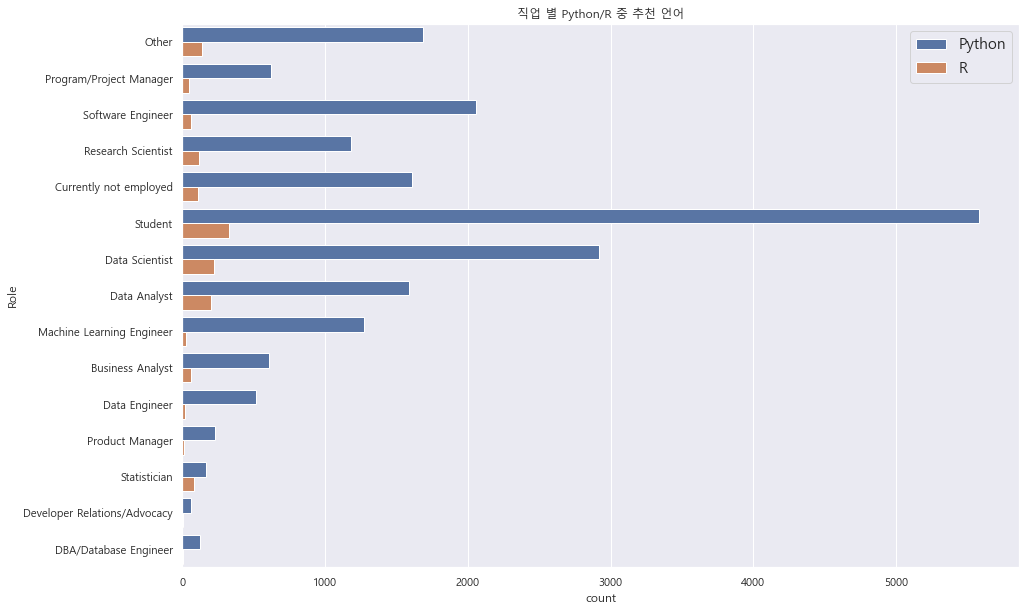

In [207]:
# 업종 별 Python/R 추천 수 
def language(answer):
    if answer['Q8']=='Python': # Python만
        return 'Python'
    elif answer['Q8']=='R': # R만
        return 'R'
answer['lang_recommend'] = answer.apply(lambda x: language(x), axis=1)
plt.figure(figsize=(15,10))
sns.countplot(y='Q5', hue='lang_recommend', data=answer, palette='deep')
plt.ylabel('Role')
plt.title('직업 별 Python/R 중 추천 언어')
plt.legend(fontsize=15)
plt.show()

대부분의 직업에서 파이썬 사용 빈도가 압도적으로 높은 것을 확인할 수 있다.   
데이터 직군에서는 파이썬을 주로 사용하지만 R도 함께 사용하는 사람들도 많은 것을 알 수 있다.   
Engineer들은 파이썬을 훨씬 더 많이 사용하며 통계학자의 경우 파이썬과 R을 모두 사용하거나 R만 사용하는 사용자가 많다.   
대부분의 직업에서 파이썬을 가장 처음 배우면 좋을 언어로 응답했다.

### 단일/다중 선택 문항 관계 없이 그래프 그려주는 함수 정의

In [148]:
def show_plot_by_qno(answer,qno,title=None):
    if qno in question.columns:
        show_countplot_by_qno(answer,qno,title)
    else:
        show_multiple_choice_bar_plot_by_qno(answer,qno,title)

## Q2. 어떤 플랫폼에서 데이터사이언스를 배워야할까요 ?
Q40. On which platforms have you begun or completed data science courses? (Select all that apply)   

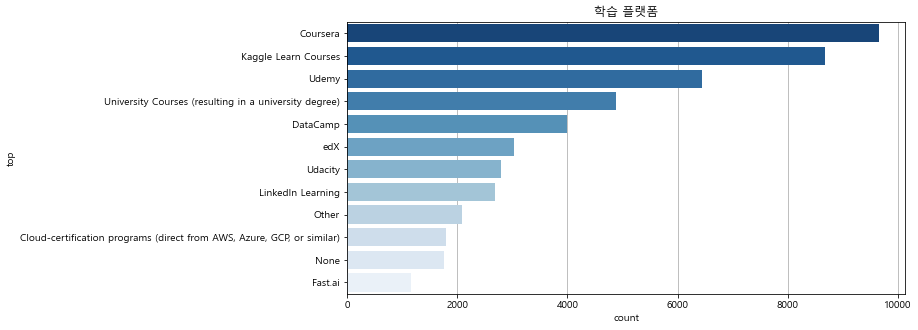

In [149]:
plt.figure(figsize=(10,5))
show_plot_by_qno(answer,'Q40', title='학습 플랫폼')

Coursera가 응답자들 사이에서 가장 많이 처음 데이터사이언스를 접한 플랫폼이다.   
Kaggle Learn Courses가 그 다음으로 높지만, 설문조사 주최가 Kaggle이므로 편향되었을 가능성이 있다.   
그 이후로는 Udemy, 대학수업, DataCamp 순으로 높다.

## Q3. 데이터 사이언스 프로젝트를 위해 높은 사양의 컴퓨터가 필요할까요?
Q11. What type of computing platform do you use most often for your data science projects?

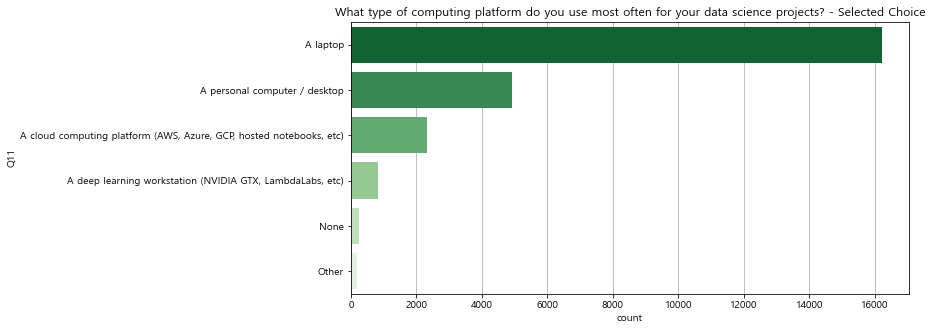

In [150]:
plt.figure(figsize=(10,5))
show_plot_by_qno(answer,'Q11')

노트북을 사용하는 응답자가 가장 많고, 데스크탑을 사용하는 사람이 그 다음이고 클라우드 컴퓨팅 환경에서 프로젝트를 진행하는 응답자가 그 다음이다.

## Q4. 어떤 개발환경을 사용해야 할까요 ? 
Q9. Which of the following integrated development environments (IDE's) do you use on a regular basis?
(Select all that apply)

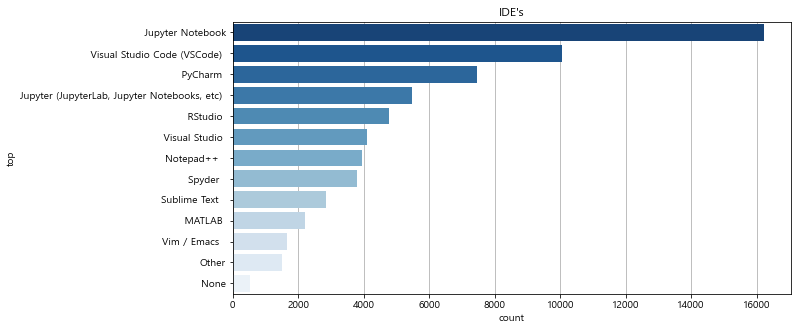

In [151]:
plt.figure(figsize=(10,5))
show_plot_by_qno(answer,'Q9',title='IDE\'s')

Jupyter Notebook을 사용하는 응답자들이 가장 많고, VSCode가 그 다음이다.

## Q5. 어떤 시각화 도구를 추천하시나요 ?

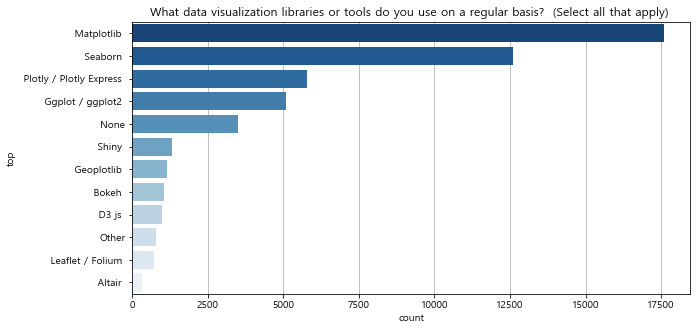

In [155]:
plt.figure(figsize=(10,5))
show_plot_by_qno(answer,'Q14')

Matplotlib , Seaborn, Plotly 순으로 응답자가 많고, 위치 기반 시각화 툴로는 Geoplotlib, Leaflet/Folium 순으로 사용자가 많다.

## Q6. 연봉은 어떻게 되나요 ? 

<AxesSubplot:xlabel='count', ylabel='range'>

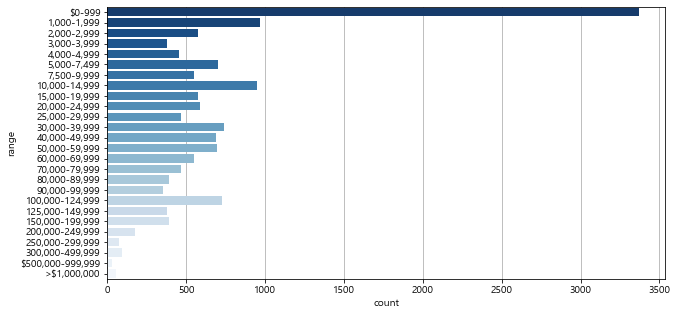

In [179]:
# 전세계 캐글러 연봉 그래프
# 인덱스 금액 순으로 정렬하기
q25_count = answer['Q25'].value_counts().reset_index()
q25_count.columns = ['range','count']
q25_count['min'] = q25_count['range'].str.split('-', expand=True)[0]
q25_count['max'] = q25_count['range'].str.split('-', expand=True)[1]
# min : 문자열 -> 숫자형으로 변경
q25_count['min'] = q25_count['min'].str.replace(',|\$|>','').astype('int')

# 최소값 기준으로 정렬
q25_count = q25_count.sort_values('min')

# 그래프 그리기
plt.figure(figsize=(10,5))
sns.barplot(data=q25_count, y='range', x='count', palette = 'Blues_r')

0-999$ 사이의 연봉을 갖는 응답자가 가장 많고, 1,000달러대, 10,000달러 초반, 100,000달러 초반의 연봉을 갖는 응답자들도 많다.

In [190]:
# 연봉 순 정렬을 위한 column list 
q25_cols = q25_count.range.tolist()

<AxesSubplot:xlabel='count', ylabel='Q25'>

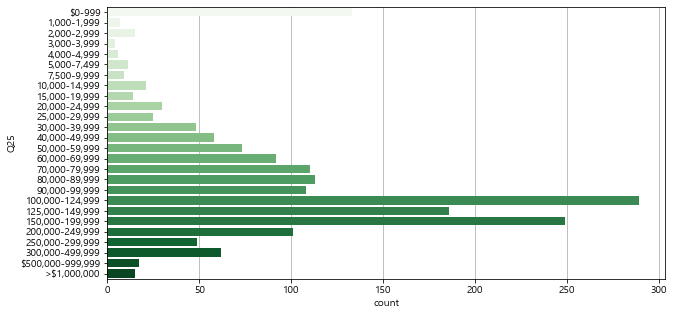

In [194]:
# 미국의 캐글러 연봉
q3_usa = answer[answer['Q3'].isin(['United States of America'])]
plt.figure(figsize=(10,5))
sns.countplot(data = q3_usa, y='Q25', order = q25_cols, palette='Greens')

대부분이 10만달러 - 20만달러 사이의 구간에 분포되어있는 것을 확인할 수 있다.

<AxesSubplot:xlabel='count', ylabel='Q25'>

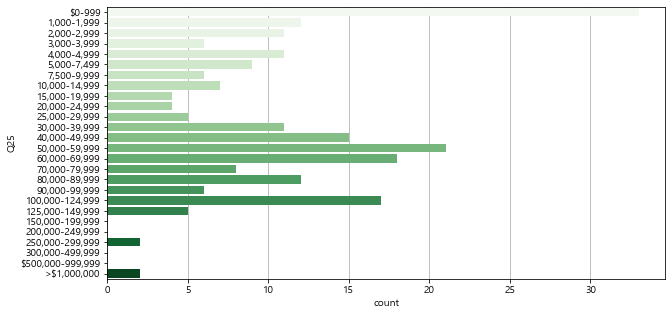

In [196]:
# 한국의 캐글러 연봉
q3_korea = answer[answer['Q3'].isin(['South Korea'])]
plt.figure(figsize=(10,5))
sns.countplot(data = q3_korea, y='Q25', order = q25_cols, palette='Greens')

0-999달러 구간의 응답자는 대부분 학생인 것으로 생각되고, 50,000달러 구간이 가장 많다.

## Q7. 어떤 클라우드 플랫폼을 사용하나요 ?

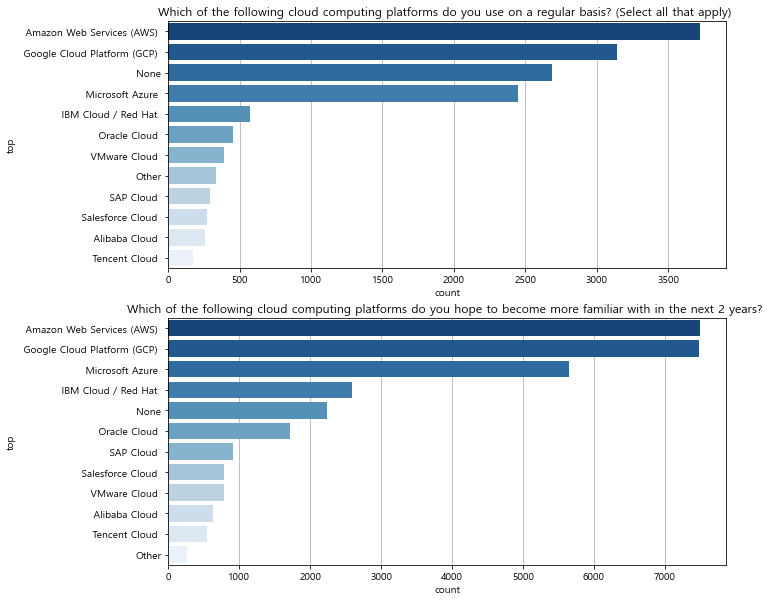

In [205]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
show_plot_by_qno(answer,'Q27_A')
plt.subplot(2,1,2)
show_plot_by_qno(answer,'Q27_B')

현재는 AWS,GCP,Azure 순으로 많이 사용하고 있고, 미래에도 동일하게 AWS,GCP,Azure 순으로 사용할 것이라고 응답했다.

## Q8. 어떤 클라우드 제품을 사용하나요 ? 

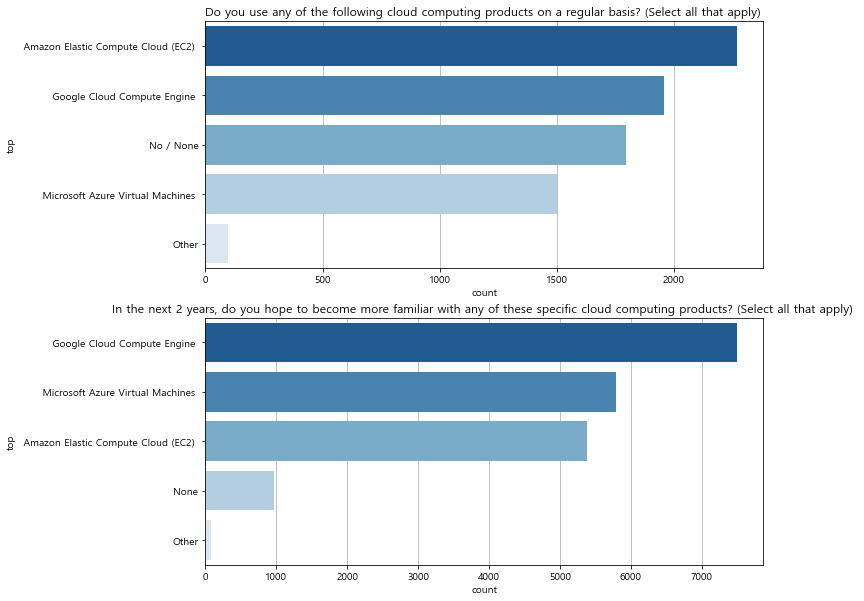

In [206]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
show_plot_by_qno(answer,'Q29_A')
plt.subplot(2,1,2)
show_plot_by_qno(answer,'Q29_B')

현재는 EC2, Google, Microsoft 순으로 많이 사용하고 있지만,   
미래에는 Google, Microsoft, EC2 순으로 사용하길 희망한다고 응답했다. 

## Q9. 가장 많이 사용하는 빅데이터 툴 ? 

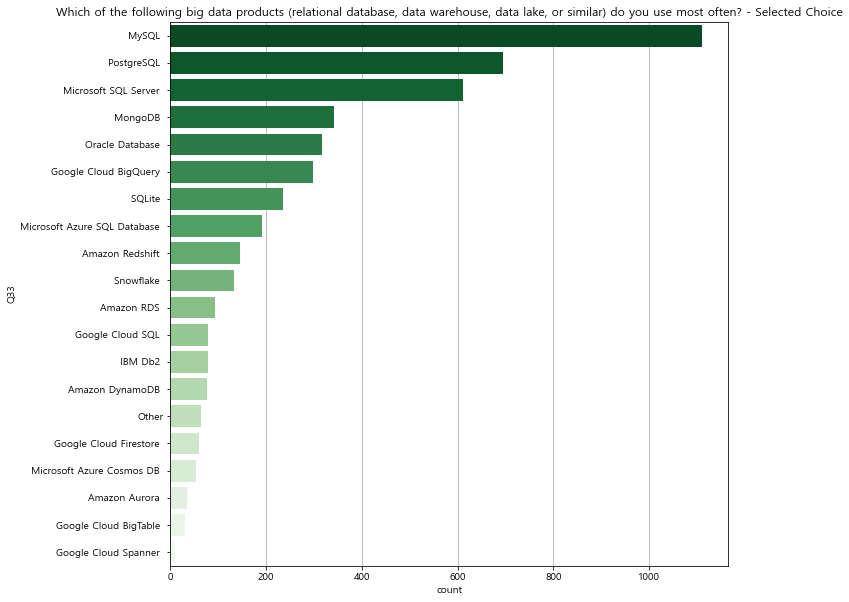

In [208]:
plt.figure(figsize=(10,10))
show_plot_by_qno(answer,'Q33')

## Q10. 어떤 경로로 다른 사람들의 작업물을 확인할 수 있을까요 ?

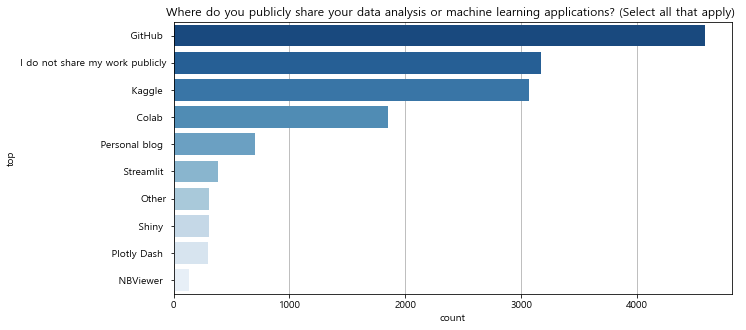

In [210]:
plt.figure(figsize=(10,5))
show_plot_by_qno(answer,'Q39')

GitHub이 가장 많고 공개적으로 공유하지 않는 응답자들이 그 다음으로 많았다.   
(생각보다 개인적인 블로그를 운영하는 사람 수가 적어서 신기하다 ,, ) 

## Q11. 어떤 툴을 주로 사용하나요  ?

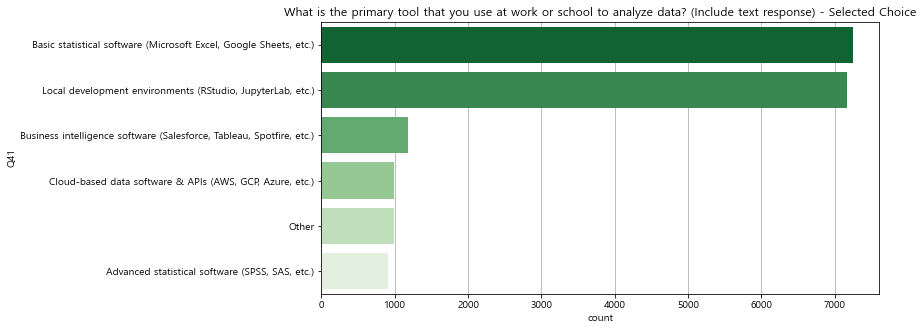

In [212]:
plt.figure(figsize=(10,5))
show_plot_by_qno(answer,'Q41')

기본적인 통계 소프트웨어와 로컬기반 개발 환경을 가장 많이 사용한다.

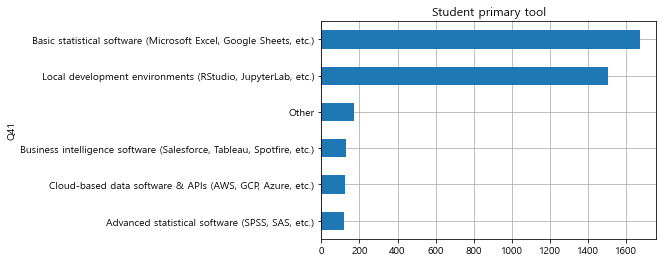

In [230]:
# 학생의 경우
q5q41 = pd.crosstab(answer['Q5'],answer['Q41'])
q5q41_student = q5q41.loc['Student']
g = q5q41_student.sort_values().plot.barh(title='Student primary tool')

학생의 경우 대부분 기본 통계 소프트웨어나 로컬 개발환경을 사용하고, 다른 툴을 사용하는 학생들은 비교적 소수임을 알 수 있다.

<AxesSubplot:title={'center':'Data expert primary tool'}, ylabel='Q5'>

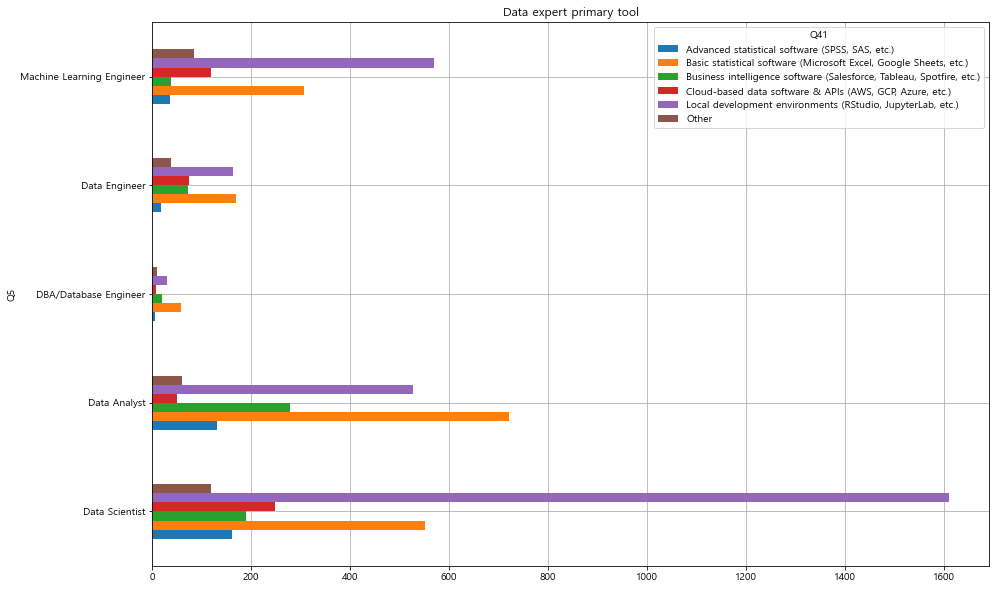

In [264]:
# 데이터 종사자의 경우
q5q41_data = q5q41.loc[set(data_cols.tolist())]
q5q41_data.plot.barh(figsize=(15,10),title='Data expert primary tool')

데이터 과학자, 머신러닝 엔지니어의 경우 로컬기반 개발환경을 많이 사용하고,   
그 외의 직군은 기본 통계 소프트웨어를 약간 더 많이 사용함을 알 수 있다.

## Q12. 어떤 매체에서 데이터 관련 소식을 얻을 수 있나요 ?

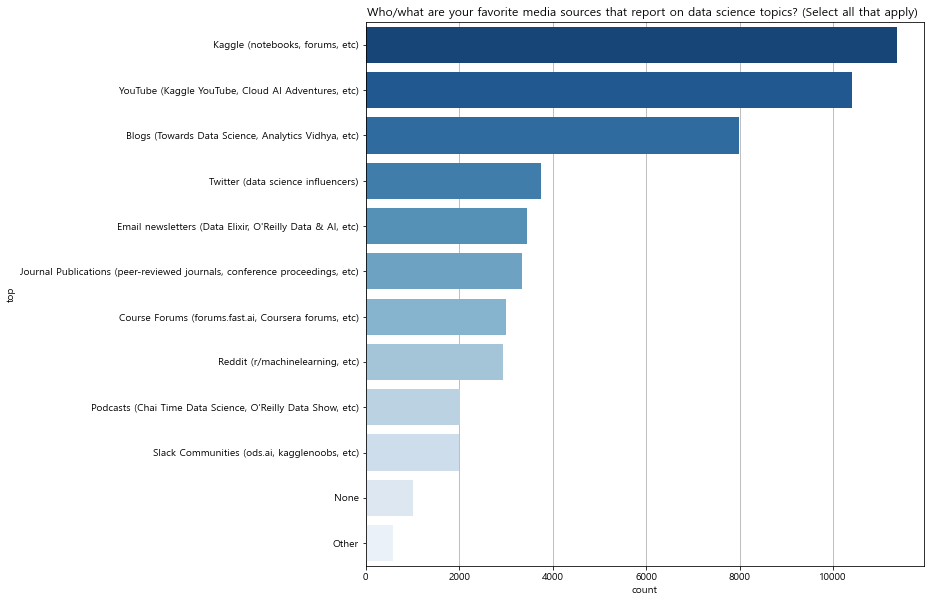

In [266]:
plt.figure(figsize=(10,10))
show_plot_by_qno(answer,'Q42')

Kaggle, YouTube, Blogs 순으로 선호도가 높다.